<a href="https://colab.research.google.com/github/AniketYouDontKnow/SE/blob/main/Personality%20Prediction%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
import random
import seaborn as sns
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
ds = pd.read_csv("mbti_1.csv", engine="python")
ds.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
mbti_type = [list(i) for i in ds["type"]]
cols = ["is_Introvert", "is_Sensing", "is_Thinking", "is_Perceiving"]
mbti_type = pd.DataFrame(mbti_type, columns= cols)
mbti_type.head()

,is_Introvert,is_Sensing,is_Thinking,is_Perceiving
0,I,N,F,J
1,E,N,T,P
2,I,N,T,P
3,I,N,T,J
4,E,N,T,J


In [4]:
# We want a 2D array as output so sparse is set to False
# Setting the output datatype to int with dtype=int
encoder = OneHotEncoder(sparse=False, drop="first", dtype=int)
encoder.fit(mbti_type)

# Converting transformed matrix to a pd.DataFrame object
mbti_type_encoded = pd.DataFrame(encoder.transform(mbti_type), columns = cols)
mbti_type_encoded.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,is_Introvert,is_Sensing,is_Thinking,is_Perceiving
0,1,0,0,0
1,0,0,1,1
2,1,0,1,1
3,1,0,1,0
4,0,0,1,0


In [5]:
encoded_ds = pd.concat([mbti_type_encoded, ds], axis=1)
encoded_ds.head()

,is_Introvert,is_Sensing,is_Thinking,is_Perceiving,type,posts
0,1,0,0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,0,0,1,1,ENTP,'I'm finding the lack of me in these posts ver...
2,1,0,1,1,INTP,'Good one _____ https://www.youtube.com/wat...
3,1,0,1,0,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,0,0,1,0,ENTJ,'You're fired.|||That's another silly misconce...


<Axes: >

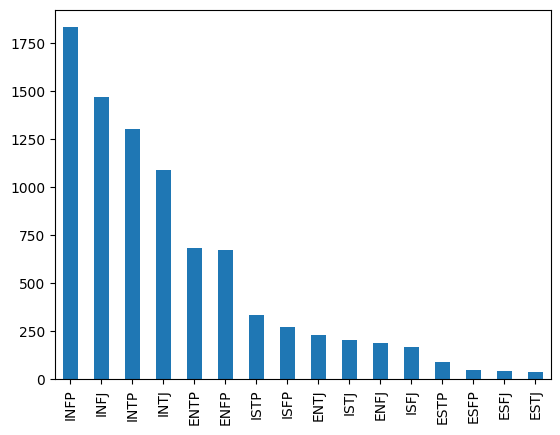

In [6]:
encoded_ds["type"].value_counts().plot(kind = "bar")

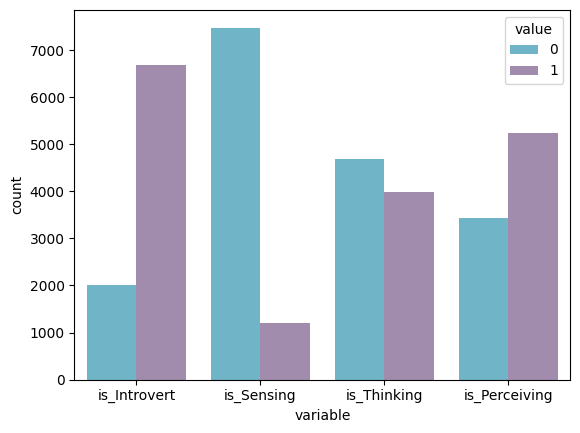

In [7]:
sns.countplot(
    x="variable",
    hue="value",
    data=pd.melt(
        encoded_ds[["is_Introvert", "is_Sensing", "is_Thinking", "is_Perceiving"]]
    ),
    palette=["#61BED6", "#A386B4"],
)

plt.show()

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

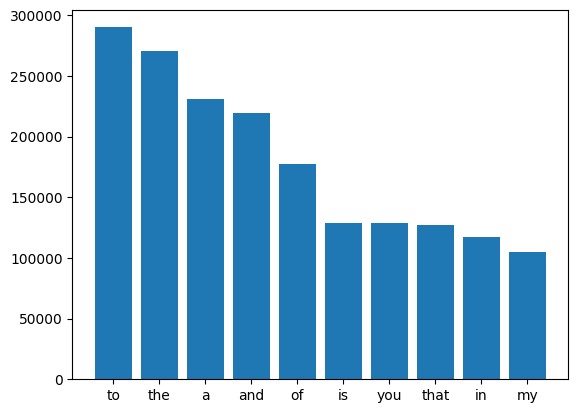

In [9]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.bar(x,y)
plot_top_stopwords_barchart(encoded_ds['posts'])

In [10]:
encoded_ds["clean posts"] = encoded_ds["posts"].str.lower()
for i in range(len(encoded_ds)):
    post = re.sub(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*", "", encoded_ds["clean posts"][i]) # Remove links
    post = re.sub("\|\|\|", "", post) # Remove |||
    post = re.sub("[0-9]", "", post) # Remove numbers
    post = re.sub("[^a-z]", " ", post) # Remove punctuation
    post = post.split()
    encoded_ds["clean posts"][i] = post

<ipython-input-10-7e9a8f2fb402>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_ds["clean posts"][i] = post


In [11]:
types = [t.lower() for t in encoded_ds["type"].unique()]
for post in encoded_ds["clean posts"]:
    for word in post:
        if word in types:
            post.remove(word)

In [12]:
encoded_ds.head()

,is_Introvert,is_Sensing,is_Thinking,is_Perceiving,type,posts,clean posts
0,1,0,0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"[and, moments, sportscenter, not, top, ten, pl..."
1,0,0,1,1,ENTP,'I'm finding the lack of me in these posts ver...,"[i, m, finding, the, lack, of, me, in, these, ..."
2,1,0,1,1,INTP,'Good one _____ https://www.youtube.com/wat...,"[good, one, course, to, which, i, say, i, know..."
3,1,0,1,0,INTJ,"'Dear INTP, I enjoyed our conversation the o...","[dear, i, enjoyed, our, conversation, the, oth..."
4,0,0,1,0,ENTJ,'You're fired.|||That's another silly misconce...,"[you, re, fired, that, s, another, silly, misc..."


In [13]:
all_stopwords = stopwords.words("english")
all_stopwords.remove("not")

def remove_stopwords(post):
    return [word for word in post if word not in all_stopwords]

encoded_ds["clean posts"] = encoded_ds["clean posts"].apply(remove_stopwords)
encoded_ds["clean posts"].head()

0    [moments, sportscenter, not, top, ten, plays, ...
1    [finding, lack, posts, alarming, sex, boring, ...
2    [good, one, course, say, know, blessing, curse...
3    [dear, enjoyed, conversation, day, esoteric, g...
4    [fired, another, silly, misconception, approac...
Name: clean posts, dtype: object

In [14]:
ps = PorterStemmer()

def stemming(row):
    return " ". join([ps.stem(word) for word in row])

encoded_ds["clean posts"] = encoded_ds["clean posts"].apply(stemming)
encoded_ds["clean posts"].head()

0    moment sportscent not top ten play prankswhat ...
1    find lack post alarm sex bore posit often exam...
2    good one cours say know bless curs absolut pos...
3    dear enjoy convers day esoter gab natur univer...
4    fire anoth silli misconcept approach logic go ...
Name: clean posts, dtype: object

In [15]:
encoded_ds.drop(["posts"], inplace = True, axis = 1)
encoded_ds.to_csv("mbti_cleaned.csv")

In [16]:
encoded_ds = pd.read_csv("mbti_cleaned.csv")
encoded_ds.head()

,Unnamed: 0,is_Introvert,is_Sensing,is_Thinking,is_Perceiving,type,clean posts
0,0,1,0,0,0,INFJ,moment sportscent not top ten play prankswhat ...
1,1,0,0,1,1,ENTP,find lack post alarm sex bore posit often exam...
2,2,1,0,1,1,INTP,good one cours say know bless curs absolut pos...
3,3,1,0,1,0,INTJ,dear enjoy convers day esoter gab natur univer...
4,4,0,0,1,0,ENTJ,fire anoth silli misconcept approach logic go ...


In [17]:
encoded_ds = encoded_ds[encoded_ds["clean posts"].notna()] # Consider only those posts that are not NaN
encoded_ds.head()

,Unnamed: 0,is_Introvert,is_Sensing,is_Thinking,is_Perceiving,type,clean posts
0,0,1,0,0,0,INFJ,moment sportscent not top ten play prankswhat ...
1,1,0,0,1,1,ENTP,find lack post alarm sex bore posit often exam...
2,2,1,0,1,1,INTP,good one cours say know bless curs absolut pos...
3,3,1,0,1,0,INTJ,dear enjoy convers day esoter gab natur univer...
4,4,0,0,1,0,ENTJ,fire anoth silli misconcept approach logic go ...


In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [20]:
def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus

    corpus=_preprocess_text(text)

    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=200,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

In [21]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

INFJ


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


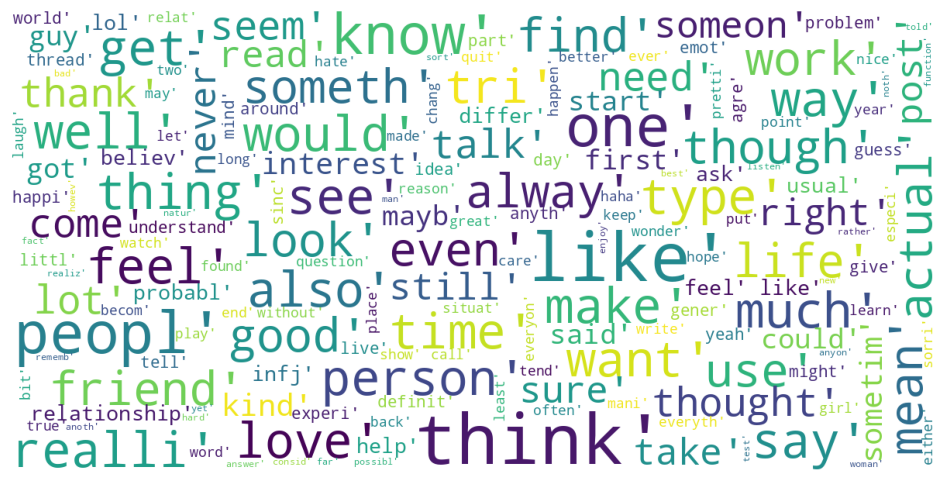

INFP


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


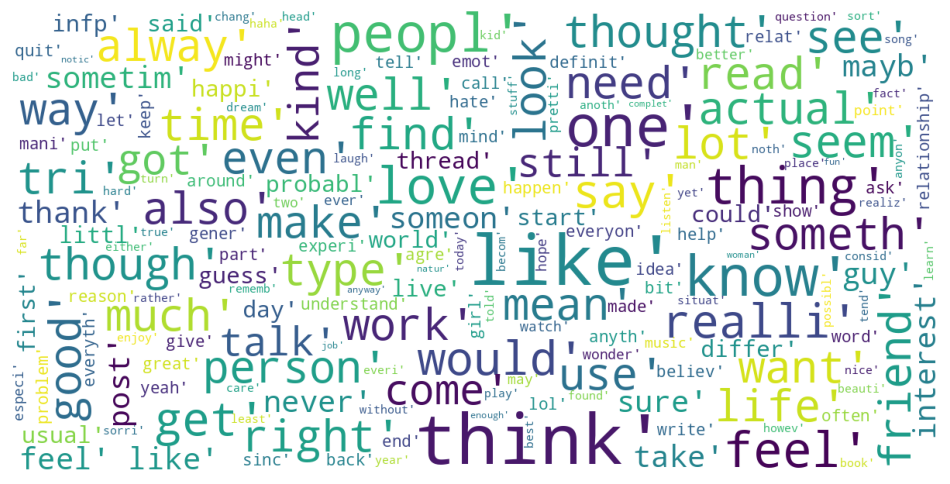

ENTP


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


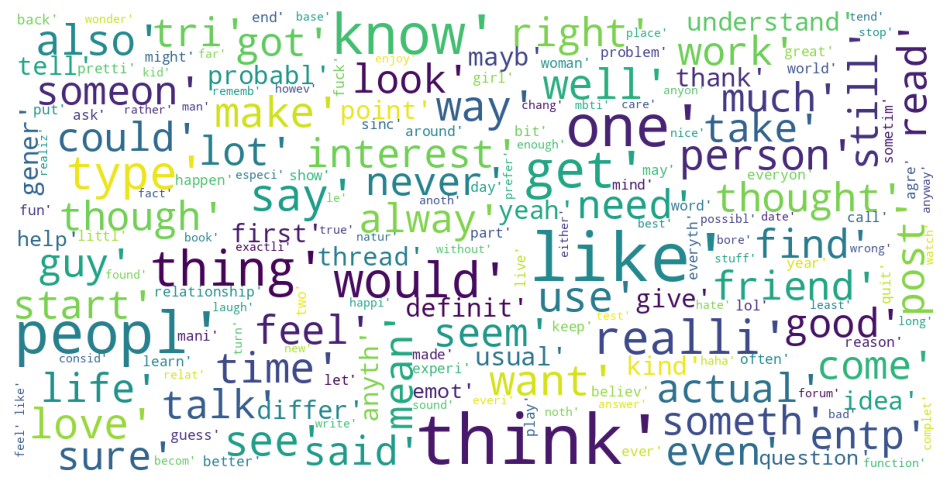

ISFP


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


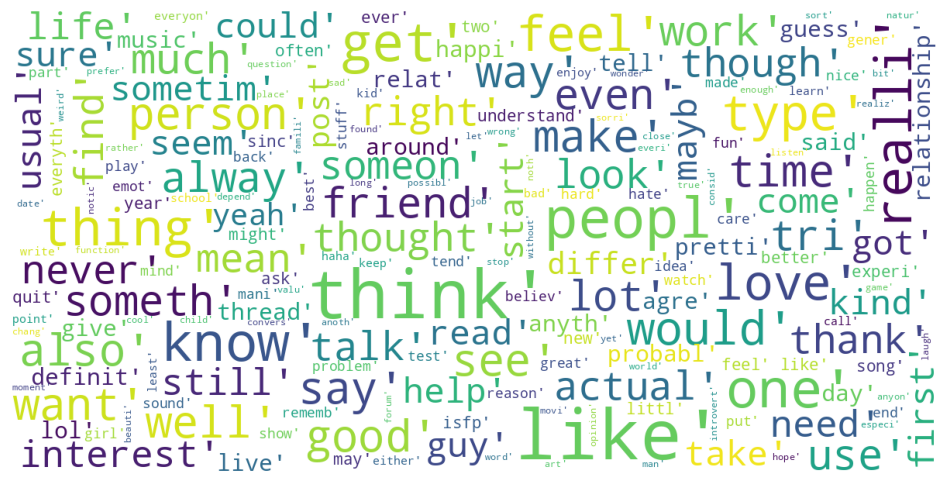

In [22]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

print("INFJ")
infj_df = encoded_ds[encoded_ds['type'] == 'INFJ']
plot_wordcloud(infj_df["clean posts"])

#Bag of words for INFP personality type
print("INFP")
infp_df = encoded_ds[encoded_ds['type'] == 'INFP']
plot_wordcloud(infp_df["clean posts"])

#Bag of words for ENTP personality type
print("ENTP")
entp_df = encoded_ds[encoded_ds['type'] == 'ENTP']
plot_wordcloud(entp_df["clean posts"])

#Bag of words for ISFP personality type
print("ISFP")
isfp_df = encoded_ds[encoded_ds['type'] == 'ISFP']
plot_wordcloud(isfp_df["clean posts"])

In [23]:
cv = CountVectorizer(max_features = 1500)
cv.fit(encoded_ds["clean posts"])

CountVectorizer(max_features=1500)

In [24]:
X = cv.transform(encoded_ds["clean posts"]).toarray()
y = encoded_ds.iloc[:, 1:5].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [25]:
cols = [
    "Introvert vs Extrovert",
    "Sensing vs Intuition",
    "Thinking vs Feeling",
    "Perceiving vs Judging"
]

model_name = ["Logistic Regression", "Random Forest", "SVM", "XGBoost"]


results = {
    "Logistic Regression" : [],
    "Random Forest" : [],
    "SVM" : [],
    "XGBoost" : []
    }

def report(y_pred, y_true, i, model_no):
    print("----------------------------------------------------\n", cols[i])
    print("\nModel name: ", model_name[model_no])
    accuracy = accuracy_score(y_true, y_pred) * 100
    print("\nAccuracy: {:0.2f}%".format(accuracy))
    results[model_name[model_no]].append(accuracy)
    print(classification_report(y_true, y_pred))

In [26]:
models = [LogisticRegression(max_iter=1000), RandomForestClassifier(n_estimators=200), SVC(),
          XGBClassifier()]

# models = [LogisticRegression(max_iter=1000)]

for m_no, model in enumerate(models):
    for i in range(4):
        model.fit(X_train, y_train[:, i])
        y_pred = model.predict(X_test)
        report(y_pred, y_test[:, i], i, m_no)
        print(y_pred)
        print(y_test[:,i])

----------------------------------------------------
 Introvert vs Extrovert

Model name:  Logistic Regression

Accuracy: 76.26%
              precision    recall  f1-score   support

           0       0.48      0.44      0.46       592
           1       0.84      0.86      0.85      2011

    accuracy                           0.76      2603
   macro avg       0.66      0.65      0.65      2603
weighted avg       0.76      0.76      0.76      2603

[1 1 1 ... 1 1 1]
[0 1 1 ... 1 1 1]
----------------------------------------------------
 Sensing vs Intuition

Model name:  Logistic Regression

Accuracy: 80.60%
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      2268
           1       0.31      0.43      0.36       335

    accuracy                           0.81      2603
   macro avg       0.61      0.64      0.62      2603
weighted avg       0.83      0.81      0.82      2603

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
------------------

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------
 Thinking vs Feeling

Model name:  SVM

Accuracy: 78.99%
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1403
           1       0.78      0.76      0.77      1200

    accuracy                           0.79      2603
   macro avg       0.79      0.79      0.79      2603
weighted avg       0.79      0.79      0.79      2603

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]
----------------------------------------------------
 Perceiving vs Judging

Model name:  SVM

Accuracy: 71.84%
              precision    recall  f1-score   support

           0       0.75      0.42      0.54      1020
           1       0.71      0.91      0.80      1583

    accuracy                           0.72      2603
   macro avg       0.73      0.67      0.67      2603
weighted avg       0.73      0.72      0.70      2603

[0 0 1 ... 1 0 1]
[1 0 1 ... 1 0 0]
----------------------------------------------------

In [27]:
results = pd.DataFrame(results, index = ["is_Introvert", "is_Sensing", "is_Thinking", "is_Perceiving"])
results

,Logistic Regression,Random Forest,SVM,XGBoost
is_Introvert,76.258164,77.410680,79.177872,80.676143
is_Sensing,80.599308,87.091817,87.130234,87.898579
is_Thinking,74.183634,75.835574,78.985786,78.179024
is_Perceiving,67.960046,66.384940,71.840184,71.609681


In [28]:
results.to_csv("prediction_result.csv", index=False)

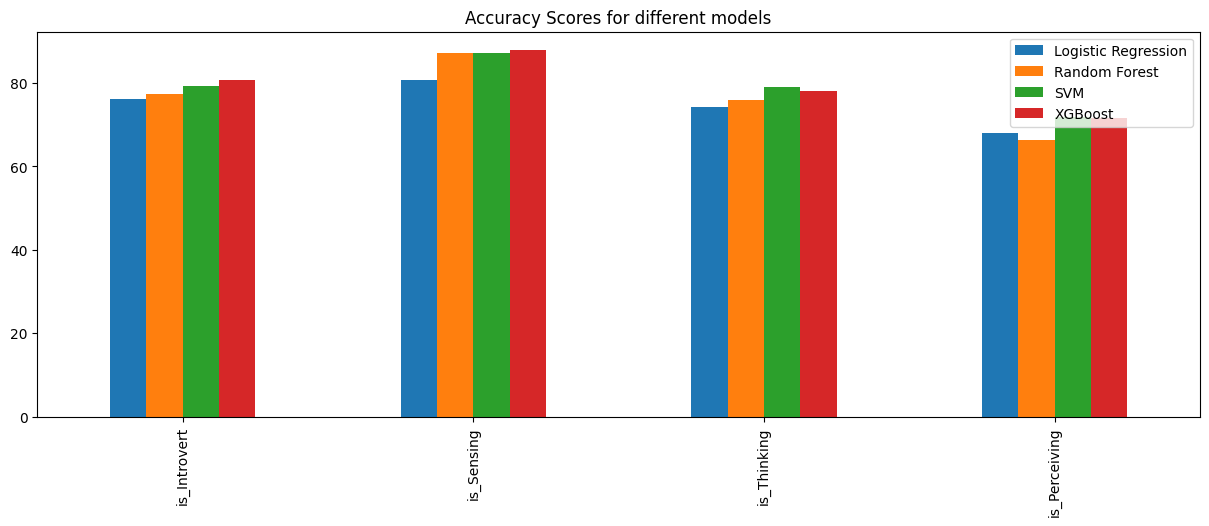

In [29]:
results.plot.bar(figsize=(15, 5))
plt.title("Accuracy Scores for different models")
plt.show()

In [30]:
introv_model = XGBClassifier()
introv_model.fit(X, y[:, 0])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
sens_model = XGBClassifier()
sens_model.fit(X, y[:, 1])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
think_model = XGBClassifier()
think_model.fit(X, y[:, 2])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
perc_model = XGBClassifier()
perc_model.fit(X, y[:, 3])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [34]:
# Save Introvert vs Extrovert model
file_name_i = "xgb_introv.pkl"

# Save Sensing vs Intuition model
file_name_s = "xgb_sens.pkl"

# Save Thinking vs Feeling model
file_name_t = "xgb_think.pkl"

# Save Perceiving vs Judging model
file_name_p = "xgb_perc.pkl"

# Saving the CountVectorizer object
file_name_cv = "cv.pkl"

In [35]:
# Save Introvert vs Extrovert model
pickle.dump(introv_model, open(file_name_i, "wb"))

# Save Sensing vs Intuition model
pickle.dump(sens_model, open(file_name_s, "wb"))

# Save Thinking vs Feeling model
pickle.dump(think_model, open(file_name_t, "wb"))

# Save Perceiving vs Judging model
pickle.dump(perc_model, open(file_name_p, "wb"))

# Saving the fitted CountVectorizer
pickle.dump(cv, open(file_name_cv, "wb"))

In [36]:
nltk.download("stopwords")
all_stopwords = stopwords.words("english")
all_stopwords.remove("not")
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
# Cleaning
def clean_data(post):
    post = re.sub(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*", "", post) # Remove links
    post = re.sub("\|\|\|", "", post) # Remove |||
    post = re.sub("[0-9]", "", post) # Remove numbers
    post = re.sub("[^a-z]", " ", post) # Remove punctuation
    post = post.split()
    post = [word for word in post if word not in all_stopwords] # Stopwords removal
    post = " ". join([ps.stem(word) for word in post]) # Stemming
    return post
def clean_pred_data(pred):
    random.shuffle((pred))

In [38]:
user_ip = """ 'Pure sass when it strikes me.It's hard to pinpoint one, but they typically have to do with being outdoors and
being overwhelmed by the beauty of nature. Climbing mountains, swimming in the ocean, hiking in the woods. Those are...Tell your therapist first. Mine was the first I told about any gay feelings and she helped me find a healthy path to understanding my sexuality. That's just part of psychology, which is what they do!...|||Ahh yes I get this feeling with all of my exes. I am on good terms with all of them, a little too good of terms with some! But I love the memories of those happy times. I always thought that I just...|||Yes! I was just going on about how I'm going to improve my health and diet just the other day, and today I have already eaten chocolate, cake and ice cream! It's not even my birthday. I have a wicked...|||I really like all of the suggestions by infpblog, but I have a simple recommendation that has helped me tremendously. If you have an iphone, there is an app called Clear. It's a really simple to-do...|||no_id Smoked. It tasted like metal and made you super high, like 5x that of weed.|||I smoke pot pretty regularly and don't think much of it. It's not for the reasons you may think, either. I am a runner and I love to smoke and get high before a run. The imagination runs wild and it...|||I agree on sensitivity, it has major advantages but some pretty profound downfalls.   My moodswings get so terrible and I hate that it affects my productivity at work. I feel like I've gotten a...|||I'd like to see this INFP map!   I'm in New York City. Strange place for an NF. We have a love/hate relationship.|||Yes! I feel this with my boss, strangely enough.  He is married and I am in an LTR, and at first I was worried that I had a crush on him. It would be so wrong and inappropriate on so many levels....|||I'm not a bachelor, but this sounds awesome.|||I lol with my lol friends, and I haha with my haha friends. I'm sort of accommodating in that way.|||I like the list format. I think it would be hard to name my favorites of all time, so I'll just name a few of my favorites and others I've recently read. I hope you can enjoy some of these! ...|||Unsolicited reading advice is about as welcome as unsolicited music and movie advice. To each his own, man.  And perhaps the Anna Karenina film that came out was a vapid little soap opera, but it...|||Thank you! Very kind to say.|||Currently reading Infinite Jest.|||Nice list!|||Yes, sounds like conflict avoidance, and yes I totally relate. I can be very chameleon-ish. I also attribute this to feeding off of other people's emotions or energy. When someone is taking a stance...|||I was bullied as a kid for being different. Something I'm sure many INFPs can relate to. I just wasn't like any of the other kids. When I was a teenager, I figured I must have been one of the bad...|||I love this, strange video too.   http://www.youtube.com/watch?v=rVeMiVU77wo|||I'm feeling very torn between the two worlds within my personality. I want to embrace my INFPness in the world, but have found that it has done me no favors in the working world, or with making my...|||sky2evan  This is good advice! I have another work commitment and can't make it to the next game, but I will say something (probably exactly what you suggested) and just go from there. On the email...|||Haha I've already thought of that!|||Thanks for this lovely reply! Your words have made me feel much better about the situation. I will try to turn this problem into a positive. Thanks again!|||I think you are mistaking religion for philosophy. Sorry, I realize that has been mentioned before.  I was raised Christian and now see myself as apathetic to how religion affects my life, but feel...|||Not really, just getting excited for the new Arrested Development :laughing:  But really, I have done something I regret. I volunteered myself for our company softball team, and I am not very good....|||Wise beyond your years! This is good advice for everyone, especially INFPs. I especially love the part I highlighted in bold. I'm sure we can all relate to this. Thank you!|||Good questions!|||My apartment is always a mess.. I sort of try to clean it, but my INTP partner tends to do most of the dirty work. We have a cat and a dog too, so it's a fair bit of work. It's an old building, which...|||Dove_Eyes  I can't exactly put my finger on it.. Not that I date by type (my partner is INTP), but I do admit that I find a solid pattern of attraction to NT males. I think what is most appealing...|||Surrender by Toni Bentley, Fresh Off the Boat by Eddie Huang, and Infinite Jest by David Foster Wallace.|||I am a shy girl with a major thing for ENTP men. So far your theory holds true.|||I get quirky a lot. Not my personal favorite, but I get it.   I come off as shy because I'm afraid to let my freak flag fly, but once I do, people start to like and accept my quirks. And f$&k 'em...|||It's very true, the increased flexibility is incredible. And to be frank, nothing shapes the butt quite like yoga ;)|||Well not really a gym rat per se... but I do take care of my body. I like to run, do yoga, go hit some balls at the batting cage, anything active and fun to keep my body lean. I don't obsess over it,...|||I don't want to have kids, and because of this, I don't really see the point in getting married. I would consider marriage if I really loved someone and they didn't want to have children either.  ...|||Hmm, I might have the definition of creepy wrong here, but she is creepy in a good way too. Sorry to sound uptight. :blushed:|||I have a female INTJ friend that I would describe as creepy. She makes no bones about letting people know when she fancies them, whether they return those feelings or not. Sadly, usually not. She...|||Greatest Strength: Compassion  Greatest Weakness: Moody/Neurotic   Quality you most admire in other people: sick math skills! Smarts. Intellectuals. Love those NTs.   Quality you least admire...|||I worry about how dark and cynical I truly am. I appear to be light and fluffy so people will not know that I am secretly worrying about bigger things at hand. I think we all do this to some extent....|||These statements really resonated with me. I don't like being teased.. even in the nicest of ways.|||I feel the same way! Pretty much summed it up right there.|||My INTP boyfriend said that he would describe me as awkward in my communication. I asked him why, and he said it was because I don't make fun of people.   Well... not to their face anyway. :P  ...|||A friend of mine, another fellow INFP, is nearly finished with her social work program and is so happy that she did. I think working 1 on 1 with people on a case by case basis is more effective for...|||I have read it, and I thought it was fantastic. I thought it was very well written and thoroughly researched.   I've always been made to feel bad that I'm significantly less extroverted that most...|||If it would help you feel better, I would gladly read your poetry. I don't know how much credibility you are looking for, but I do live in New York and have worked in publishing. Plus I love to read!...|||I don't like potatoes.|||I have a BA in Communication. It really helped me get out of my shell during my college years. I jumped right back in after I graduated,
but I'm doing alright!I'm glad that you've found my advice helpful :) you will make it through these difficult times.'
"""
post = user_ip.lower()


# Preprocessing
post = clean_data(post)


# Load the prefitted count vectorizer
cv = pickle.load(open("cv.pkl", "rb"))
# Convert to matrix of tokens
post = cv.transform([post])

In [39]:
# Load all models
xgb_model_introv = pickle.load(open(file_name_i, "rb"))
xgb_model_sens = pickle.load(open(file_name_s, "rb"))
xgb_model_think = pickle.load(open(file_name_t, "rb"))
xgb_model_perc = pickle.load(open(file_name_p, "rb"))

def final_type(pred):
    mbti_types = [
                  ["E", "I"],
                  ["N", "S"],
                  ["F", "T"],
                  ["J", "P"]
                ]
    ans = []
    for i, p in enumerate(pred):
        ans.append(mbti_types[i][p[0]])
    return "".join(ans)

prediction = [
              xgb_model_introv.predict(post),
              xgb_model_sens.predict(post),
              xgb_model_think.predict(post),
              xgb_model_perc.predict(post)
              ]

print("Your MBTI type is: INFP\nPredicted Personality type is:", final_type(prediction))

Your MBTI type is: INFP
Predicted Personality type is: ISFJ


In [40]:
# INFP
post_1 = """'Pure sass when it strikes me.|||It's hard to pinpoint one, but they typically have to do with being outdoors and
being overwhelmed by the beauty of nature. Climbing mountains, swimming in the ocean, hiking in the woods. '"""


# ENFJ
post_2 = """It burns!! Haha|||http://personalitycafe.com/mafia/701778-mafia-open-iii-big-hero-6-signups.html Go here|||You're right.
Not sure why I didn't think of that before hahah|||BAHAHAH omg that avatar. I love it.|||Hmmm...well let's see...you like science
and art...|||You don't have to lol. What picture are you thinking for an avatar?|||You can change it in settings|||You should probs choose an avatar|||Hi! This is obvi my username|||I've known my INFP husband for about 8 years. We've been together for 5 years, and married for 1 year. We are in a very happy and healthy relationship. :) We bought our first house together and are...|||I'm married to an INFP, so I'll offer this bit of info. from my personal experience:  When it comes to relationships, I'm very old fashioned in that I love the man to ask me out and make the first...|||My husband is an INFP. From a biased point of view, I agree that INFP is an excellent fit. :P|||Welcome!|||Welcome!!|||Welcome!! :)|||I own a Chumbawumba album...haha|||$300 sneakers...lol|||Creative, outcast, strong minded characters such as Holden Caufield.|||Welcome!! :)|||I've always identified myself with Belle from Beauty and the Beast!|||I function better in social settings. I work better in groups when I am able to bounce my ideas around, get feedback, and socialize. I'm happier around people. I do enjoy alone time, but too much...|||My husband is INFP. We get along so well, but we do have our differences. Lol|||Welcome!! :)|||Welcome!!! :)|||Welcome! I'm ENFJ as well. :)|||Welcome!! :)|||Welcome!! :)|||(Deleted)|||(Deleted)|||(Deleted)|||(Deleted)|||I've been so curious about my Enneagram type since I learned it existed lol. If possible, could someone help me figure it out? I don't know anything about what the numbers mean, so explanations would...|||Thanks!!! :) ENFJ/INFP: Volume 2 - Parenting. Hahaha.   He is adorable and he tries so hard lol. It's very endearing, even if annoying at times. :P lol|||Money is the hardest, I think, for us to come to terms with. He is very idealistic in his thinking. He believes as long as we have love, money means nothing. While I do believe love is more important...|||I'm a teacher in New England (to give context since education varies all over the place). I teacher high school English.  I hate common core. I know it for purposes of educational politics. Schools...|||As a high school teacher, I have very strong beliefs on this subject. Testing students is meaningless...unless you're testing skills in hacking a system. It does not measure what is learned in...|||I haven't read every post, but the title intrigued me. I just recently got involved with this forum a few months ago, and at that time, I discovered my MBTI. I had my husband figure his out, too. I'm...|||Wontly has it right! Hahah I haven't read the thread, but I agree with any and all who do not like Taylor Swift. Her lyrics, her voice, her melody...it's pain to my ears. cue5c tortured me so bad in...
"""


# ISFP
post_3 = """'ponyjoyride Thankyou, Im not sure how I shoudl say it, but i almost made nf land seem like heaven XD ill remember to put good and bad people in there|||How does your desire
to make others lives better err...manifest?|||Like the title says, im making a game where this girl gets a magic music
score that transports her to another world full of nfs. The specific place will be either a town or kingdom (like in the...|||Dangit you people should stop being smart AND not socially awkward. I guess you make up for it by being incredibly disorganised and terrible at finishing things.|||Thanks for all the replies, guys. If you know all these flaws about people, how do you choose who to be friends with? I can't imagine being friends with someone who'd just know my bad qualities (we...|||Intps because inferior Fe, and introverts tend to have less practice at socialising. Also, ne and ti often make a person hard to talk to imo (for sensors) and their interests are unusual. Of course,...|||QUESTIONNAIRE ONE 1. Click on this link: Flickr: Explore! Look at the random photo for about 30 seconds. Copy and paste it here, and write about your impression of it. 331378 I liked the way the...|||Most: infj, isfj, enfj Least: estp, istp|||According to various infj descriptions, infjs have uncanny insight into people and understand them better than they can. Can you explain how you do this, and why other types may not have this...|||*cringe* I was so convinced id gotten it right with xnfp. Only now do I realise my strengths lie in Se stuff. Heck, I don't even know if I'm isfp, but the only othe option is esfp,|||I really don't think I have Fe...when I answered the questionnaire I was actually an unhealthy type and going through depression. Also, rejection has been a major theme throughout my life, and I'm...|||Zee Bee sorry, what?|||This was a long time ago, at the time I had a huge crush on this boy and decided to confess to him. I never showed it to him but... *shudder*   Dear xxxxx, I think you're awesome because you're...|||Hmmm, I got infp, but I feel like I could be isfp. I do like typical Se activities - personal grooming, going out etc - but I'm also into intuitive pursuits. I don't know...the two are so similar and...|||The Shark I don't know if what you said about being unacceptable is true...I thought that mbti was just about how your mind worked and not about behaviour (I'm not talking about actions, I mean your...|||Er I'd say that genetics and circumstance is a factor, but a person's personality definitely matters. Overall, I think idealistic people are less happy because the world is so low, and the things...|||The Shark to be honest, there are a lot more nf females than males, so it's easier for you guys to find girls with NF qualities. I also think that NF males are choosier than their female counterparts...|||Most marriages I see end in divorce, and if they don't, it's only because the parents don't want to upset their kids. Even NF marriages don't last that much more than other marriages. They are such...|||Bahaha  Raawx if you're reading this, I don't know what to say. I guess I'll just talk about what I hate? I hate the idea of hierarchies, the idea that someone or group is better than another. I...|||Darn this thread is too popular :'( no chance of me getting typed. Waah|||wums  I agree with part of what you're saying, but there are some parts that I think don't apply to me. I'm apparently a very annoying person to be around (socially awkward), so I think that my...|||Im not an isfp, but isnt being offended just feeling some degree of hurt over something that has happened or been said? I believe that the more self-conscious someone is, the more easily they take...|||wums sorry, I have an off-topic question. My brother has told me he hates 'stupid people', and that I'm not smart (this was in two separate occasions) repeatedly. Also, when I tell him about my...|||wums mind= blown. You should be a therapist/counsellor... Nah I get that you weren't trying to offend me, it's cool.|||wums Huh. Does it last with the intjs because they're can't be bothered to cheat? To me, they seem like very dispassionate people, the type to passionately propose in a fit of...obligation ._. ...|||Ahah it kinda makes me wonder if there'll be a project for women to be more logical. I can't imagine the name of it, but I can see it happening.|||Let's start a social revolution :')|||I think I might agree with you. For a long time, I've had this idea that judgers are less likely to cheat than perceivers. Of course my idea is very judgemental as I haven't actually tested the...|||Curiously, it appears that female Idealists are able to sustain the roman- ticism invested in a relationship longer than male Idealists. But for the male NF, anticipation can be more attractive than...|||I do. I dislike items given to me by people who aren't in my good books and love gifts given by loved ones. The closer I feel to the person the item came from, the more attached I am to it. It is...|||1- Ni doms 2 - Fe dom or aux 3 - i dunno 4 - Fi doms or ni doms 5 - ti doms or ni doms (infj less likely)  6 - si dom or aux 7 - se or ne dom 8 - te doms 9 - fi doms|||I do wish I was less sensitive and needed people less. Does that count as thinking over feeling?  I don't know good ways to develop si and te, but I know a way: hang around xstjs, live with them and...|||I like easy games that make me feel happy but have something special :) like socrates jones, pokemon, narrative flash games, ah i cant remember them all, but they've given me great joy|||Is there a way to achieve  the energising effect of social interaction, but without having to talk to anyone?|||aHumanRenaisance being weird even among other infjs, huh :laughing:|||*in a debate* Other person: Your argument is invalid because x=y, therefore z. Me: ...you're wrong because ur face is ugly! *flees*|||I think i can make an exception ;D go on, use 6 words.|||I relate, but I blame it on my add and genetics. It seems like no one really enjoys my company, except for animals, and even then there are exceptions. It is depressing, but I guess this is nature's...|||Ziggurat I've been around a lot of sensors and so I usually make small-talk about what's happening (not politics). I heard that intps really dont like ordinary talk and get bored by it so I'm...|||If someone wanted to have a conversation with you, how should they approach it and what should they talk about?|||Fe-doms for sure are friendly, and exfp are next up. It's really a matter of fe vs se vs ne, and I don't know enough to tell which would be considered the 'friendliest' function. Friendly as in warm?...|||Bored|||Dominant fe doesnt mean a person is insincere :happy:|||Welcome!|||Sheesh stop trying to rescue that baby when it's with its mum. Not everyone needs to be rescued.|||Sure sure. Remember warren buffet? He created lots of moneys|||Unhealthy Intj...theyre 3 smart 5 you.|||Fi comes to bite them in the butt...I'm somewhat new to mbti theory. Can you explain what you mean by that? And yep I guess it does even out because we develop our functions more with age...|||Holy mother f*** this is so cute! I love almost unreal love stories like these that actually have happened! This made me tear up and squeal like a little girl. Yay for necromancing posts up!|||You know infps will always accept fellow infps :) although I don't really have a right to say that because I'm unsure of my infp-ness.'
"""

# INTP
post_4 = """'Yes yoda, it took a while to understand but think I do. I tell myself
I'm waiting for the right moment, for the right information to surface, for the right motivational boost.. Maybe it must come...|||I don't know what to do with myself. Years have gone by, so many thoughts so little done about them..
Is daily cannabis smoking to blame? Perhaps. I think that's shirking the blame a bit though..For I...|||I hate when there's a little bit of
smoke left in my lungs after taking a toke...I end up breathing out as much as I can which just looks and sounds strange but I can't help but do it. :(|||Like I said, you're acquainted with cretins.  MDMA is a stimulant. MDMA is then, by defintion of a stimulant, a drug. How can they be apples and oranges when by definition the apple is a type of...|||Prom you forgot to post the article about THC's effect on lung cancer in mice, that's always a good one for the anti's. ...|||They're beyond mine too if I'm honest, I only know bits and bobs - never been too concerned with the stuff.    Not sure why those articles were directed at me lol but yeah it has certainly taken...|||This sounds pretty true, but not so much I don't think for the U.K. I think the fuel for drug prohibtion here is basically a combination of the remnants of anti-drug propaganda from the 70's and...|||I'm not quite sure I know what you mean :S I think I'm saying if you realise that objectively, there's a clear greater good to lifting prohibtion, then what's considered morally right or wrong for...|||Yeah this is the core problem and it's difficult to answer objectively without a shit load of stats. This might be an overly simplistic way of looking at it but I like to think of it as walking...|||You mean, should it be legal for people to choose for themselves? ;) Yes, no organisation can/should dictate what we can and can't do to our own minds and bodies. To try and do so is a waste of...|||This is fairly common, I know I daydream like you're describing - hypothetical conversations and situations. It's an INxx thing I think. So no advice, it's just part of you ;)|||I've been in a similar situation...It's tricky, some people seem to think that if they're your mate, you owe them the time to have a conversation. Tell her this isn't the case, that you like talking...|||I've found distraction to be most effective. Do things that feel important to you and eventually you'll forget why you were even depressed in the first place.|||I think you'll find many people who've taken Ayahuasca will disagree  with you there. You know psilocybin, (active ingredient in magic mushrooms) MDMA and LSD were being tested as treatments for...|||My sleep pattern is pretty fucked at the moment. I like to stay up until early hours of the morning like 5-6am but I need to get up at 8-9am on more than one day a week. The end result is me sleeping...|||Shame is subjective and thusly a weak, ineffective form of criticism.|||Migraines are for the weak.|||Yeah but there's no need to be a dick about it. lol.|||I honestly have no clue but googled and this might help:  Beverage Sales and Distribution : How to sell your new beverage to retailers.  Maybe try using the contact seciton and explaining your...|||You should have responded quicker. :D|||It is their decision to conform to the requirements stated in the OP.|||Yeah you were right lol pity I turned off my PC before reading your reply else I could have saved myself an hour laying in bed. Aw well cheers anyway.|||Yeah the thing is I was a fair amount more awake the last time...After googling there seems to be a lot of mixed opinions on the matter. What if 1.5 hours sleep would do me better than none? I just...|||I have to be up at 8am, I could probably sleep now (2 and a half hours sleep) but I have a feeling I'll be very groggy after that and may end up just turning my alarm off and going back to sleep. I...|||Because being close to the truth is better than nothing. I'd rather have a vauge idea of what's going on than to turn a blind eye due to fear of doubt.|||You need to come out of your shell|||Dancing..more specifically clubbing. I see the philosophical implications but at the same time it seems so fucking absurd. It's horrible because I end up forcing myself to go out with people clubbing...|||I'm not completely sure about it either. I think it's something along the lines of if you don't, you're not likely to meet nearly as many like minded as people as you could have simply given the...|||Awesome post, cheers. Unfortunately I don't have an mp3 player lol and yeah I know the one, was the last good album they released before they turned to shit. (imo)|||Very useful posts thanks a lot.|||Would be good to hear how you guys dealt with this.  I find the idea of becoming more social and putting myself out there more quite a refreshing one but at the same time I wonder if I'll be too...|||Exactly how I'd feel.|||1) To be honest I can go a long time without real social contact without becoming depressed or agitated in any way, but I'd say I need a minimum of 2 or 3 days alone time if I've been out with mates...|||http://www.youtube.com/watch?v=nRnZtn1a9bM|||http://www.youtube.com/watch?v=FCxc0Laqyqo|||I was about to try and describe it to you (something that's pretty hard to do well) but this will be much simpler: Erowid MDMA Vault : Effects  If there's one piece of advice I can give you, it's...|||Such a hard decision..Cannabis aside I'd go with shrooms, though when I get a hold of some mescaline that may change. I definitely prefer psychedelic trips and visuals to the physical effects of...|||The brown/yellow bits are the bane of my life.|||Smoke a bit of bud (or hash) and see how you react. Smoke more until you've reached a comfortable high. If you can go the night without anxiety attacks, paranoia or any other mental health problem...|||How can thy derail that which is UNDERAILABLE. Someone must know the reference..|||Toasted, or not toasted: that is the question.|||http://www.youtube.com/watch?v=IW_NLi_WFYg  Super chilled.|||Physics all the way. Don't have much care to be teaching though, I'd like to get myself into research asap.|||Games/series i've loved over the years:  -Battlefield FTW -Warhammer 40k: Dawn of War -Dead Space -Mass Effect -Fallout -EVE Online -GTA -Halo|||This is so true...|||Take on a career in what you want, not what your mother wants.|||That seems like a rash decision. The only reason I made this thread was purely because I was curious about the statistics, if people are going to misinterpret that as spam then fine. But leaving over...|||Yeah I thought it was pretty cool...A bit predictable, plot structure is a bit standard but I'd say it's definitely worth the watch.|||You stand up, put your arm behind you and wipe.|||My Perceiving and Intuitive have been very close to the borderline on other tests, the most recent as shown below still has a pretty low P.'
"""

In [41]:
# Prediction for above posts
post = user_ip.lower()

# Preprocessing
post = clean_data(post)

# Load the prefitted count vectorizer and Convert to matrix of tokens
cv = pickle.load(open("cv.pkl", "rb"))
post = cv.transform([post])

prediction = [
              xgb_model_introv.predict(post),
              xgb_model_sens.predict(post),
              xgb_model_think.predict(post),
              xgb_model_perc.predict(post)
              ]

print("Your MBTI type is: INFP\nPredicted Personality type is:", final_type(prediction))

Your MBTI type is: INFP
Predicted Personality type is: ISFJ


In [45]:
q1="Q1. You joined a new company and it's your first day there.No one seems interested in helping or starting conversation with you. You will.."
q2="Q2. Do you like working in a team or performing individually? Explain Why? "
q3="Q3. When you encounter an unknown problem, do you rely on facts or try to generate new possibilities? Explain. "
q4="Q4. You are assigned with difficult project with very short deadline, what will your strategy?"
q5="Q5. How do you influence other people: Strong emotional appeal or  great logical explanation? Explain why? "
q6="Q6. In an emergency situation, like a fire, how are you likely to react? (assume you're the only one involved)"
q7="Q7. Do you like to make decisions quick or do you like to take your time to look at it from different sides?"
q8='''Q8. Consider youself the leader of an important project but your suboordinated are not cooperating with you and not following your instructions seriously.
      What would be your approach? '''

a1="If no one seems interested in helping or starting a conversation with me on my first day at a new company, I would take the initiative to introduce myself to others, show enthusiasm, and ask for assistance or guidance when needed. Building positive relationships and demonstrating a proactive attitude can help break the ice and foster collaboration."
a2="Personally, I enjoy working in a team. Collaborating with others allows for diverse perspectives, pooling of skills and knowledge, and the opportunity to learn from one another. Teamwork also promotes a sense of shared responsibility and can lead to more innovative solutions through brainstorming and collective problem-solving."
a3="When encountering an unknown problem, I believe in exploring both facts and generating new possibilities. It is crucial to gather relevant information and analyze the situation objectively. However, being open to new possibilities and thinking creatively can lead to innovative approaches and solutions that may not have been initially apparent."
a4="When assigned a difficult project with a short deadline, I would first prioritize tasks and break them down into manageable chunks. I would communicate with the team to ensure everyone understands the urgency and specific objectives. Delegating tasks based on individual strengths and expertise can help maximize efficiency. Regular progress monitoring and effective time management would be essential to meet the deadline successfully."
a5="In influencing others, I believe in using a combination of both strong emotional appeal and logical explanation. Emotional appeal can help create a connection, empathy, and motivation, while logical explanations provide a rational basis for decision-making. By striking a balance between the two, I can present a compelling argument that appeals to both the emotions and the intellect of others."
a6=" In an emergency situation like a fire, my primary instinct would be to prioritize safety and take immediate action to ensure my own well-being. I would follow established emergency protocols, evacuate the area if necessary, and alert the appropriate authorities. If safe to do so, I would also try to assist others in need and ensure their safety."
a7="When making decisions, I prefer to take my time to look at the situation from different sides. It is important to gather relevant information, consider various perspectives, and evaluate potential consequences before reaching a conclusion. Taking the time to analyze and weigh the options can lead to more informed and thoughtful decisions."
a8="As the leader of an important project, if my subordinates are not cooperating and not following instructions seriously, my approach would be to first understand the reasons behind their behavior. I would foster open communication and create a supportive environment where they feel comfortable expressing their concerns or challenges. By addressing their issues and providing clear expectations, guidance, and motivation, I would strive to inspire their commitment and align their efforts with the project goals. Building trust and leading by example can help in gaining their cooperation and turning the situation around."


In [46]:
ans= a1+a2+a3+a4+a5+a6+a7+a8

In [47]:
print("Final Responses: ",ans)

response = ans.lower()

# Preprocessing
response = clean_data(response)

# Convert to matrix of tokens
response = cv.transform([response])

def final_type(pred):
    clean_pred_data(pred)
    mbti_types = [
                  ["E", "I"],
                  ["N", "S"],
                  ["F", "T"],
                  ["J", "P"]
                ]
    ans = []
    for i, p in enumerate(pred):
        ans.append(mbti_types[i][p[0]])
    return "".join(ans)

prediction_q = [
              xgb_model_introv.predict(response),
              xgb_model_sens.predict(response),
              xgb_model_think.predict(response),
              xgb_model_perc.predict(response)
              ]

print("\nPredicted Personality type is:", final_type(prediction_q))

Final Responses:  If no one seems interested in helping or starting a conversation with me on my first day at a new company, I would take the initiative to introduce myself to others, show enthusiasm, and ask for assistance or guidance when needed. Building positive relationships and demonstrating a proactive attitude can help break the ice and foster collaboration.Personally, I enjoy working in a team. Collaborating with others allows for diverse perspectives, pooling of skills and knowledge, and the opportunity to learn from one another. Teamwork also promotes a sense of shared responsibility and can lead to more innovative solutions through brainstorming and collective problem-solving.When encountering an unknown problem, I believe in exploring both facts and generating new possibilities. It is crucial to gather relevant information and analyze the situation objectively. However, being open to new possibilities and thinking creatively can lead to innovative approaches and solutions 